# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn import ensemble, model_selection, metrics 

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [113]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
print(X.shape)

(506, 13)


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=None)

In [115]:
print(X_train.shape)

(379, 13)


In [116]:
n_train_samples = X_train.shape[0]
n_train_samples

379

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [117]:
def loss(y_true, y_pred):
    return np.mean((y_true - y_pred)**2, axis=0)

In [118]:
def loss_derivative(y_true, y_pred):
    return y_true - y_pred

In [119]:
def gbm_predict(X, base_algorithms_list, coefficients_list):
    y_pred = [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
    return np.asarray(y_pred)

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [120]:
n_trees = 50
max_depth = 5
random_state = 42

base_algorithms_list = []
coefficients_list = []
predictions_list = []
mse_errors_list = []
mse_sklearn_errors_list = []

In [121]:
current_prediction = np.asarray([0]*n_train_samples)
for i in range(n_trees):
    current_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
    current_coefficient = 0.9
        
    residuals = loss_derivative(y_train, current_prediction)
    print(current_prediction[:5])
    current_tree.fit(X_train, residuals)    
    
    base_algorithms_list.append(current_tree)
    coefficients_list.append(current_coefficient)

    current_prediction = gbm_predict(X_train, base_algorithms_list, coefficients_list)
    
    predictions_list.append(current_prediction)
    error = loss(y_train, current_prediction)
    mse_errors_list.append(error)
    current_error = mean_squared_error(y_train, current_prediction)
    mse_sklearn_errors_list.append(current_error)

[0 0 0 0 0]
[24.102      20.48068966 31.8675     31.8675     31.8675    ]
[24.0102     22.19925484 36.56328605 33.34403745 34.93779392]
[24.34648444 21.63489343 35.99892464 32.77967604 34.37343251]
[24.69302823 21.98143722 36.0620521  33.12621983 34.7199763 ]
[24.78287823 21.52195299 36.1519021  33.21606982 34.80982629]
[24.15934048 21.30908401 35.43302472 33.44058951 35.03434598]
[24.64267153 21.35941326 35.48335397 33.49091876 35.08467523]
[24.5233785  21.24012023 35.36406095 33.28995694 34.9653822 ]
[24.55364066 21.27038239 35.3943231  33.3202191  34.99564436]
[24.36175334 21.2392808  35.36322151 33.27864951 36.07956444]
[23.95303868 21.59174916 35.35521432 33.27064232 36.43203279]
[23.97455557 21.61326605 35.37673121 33.29215921 36.45354969]
[23.98390733 21.62261781 34.76767312 33.2374804  36.46290145]
[23.9934274  21.63213789 34.7771932  33.24700047 36.47242152]
[23.98152215 21.62023264 34.76528795 33.23509523 36.46051627]
[23.99284406 21.58174837 34.72680368 33.30382294 36.461470

In [122]:
y_train[:5]

array([24. , 21.6, 34.7, 33.4, 36.2])

In [123]:
mse_sklearn_errors_list[0]

12.331605457099899

In [124]:
mse_errors_list[0]

12.331605457099899

In [125]:
current_prediction = gbm_predict(X_test, base_algorithms_list, coefficients_list)

In [126]:
current_prediction[:3]

array([14.07851444, 15.48786565, 14.13609346])

In [127]:
y_test[:3]

array([10.2, 10.4, 10.9])

In [128]:
current_error = mean_squared_error(y_test, current_prediction, squared=False)

In [129]:
current_error

5.455623403859612

In [130]:
mean_squared_error(y_test, current_prediction, squared=True)

29.763826724740735

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [134]:
n_trees = 50
max_depth = 5
random_state = 42

base_algorithms_list = []
coefficients_list = []
predictions_list = []
mse_errors_list = []
mse_sklearn_errors_list = []

current_prediction = np.asarray([0]*n_train_samples)
for i in range(n_trees):
    current_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
    current_coefficient = 0.9/(1.0 + i)
        
    residuals = loss_derivative(y_train, current_prediction)
    current_tree.fit(X_train, residuals)    
    
    base_algorithms_list.append(current_tree)
    coefficients_list.append(current_coefficient)

    current_prediction = gbm_predict(X_train, base_algorithms_list, coefficients_list)
    
    predictions_list.append(current_prediction)
    
    error = loss(y_train, current_prediction)
    mse_errors_list.append(error)
    
    current_error = mean_squared_error(y_train, current_prediction)
    mse_sklearn_errors_list.append(current_error)

In [135]:
current_prediction = gbm_predict(X_test, base_algorithms_list, coefficients_list)
mean_squared_error(y_test, current_prediction, squared=False)

4.812550945781193

In [136]:
mean_squared_error(y_test, current_prediction, squared=True)

23.160646605739455

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [137]:
import xgboost as xgb

In [154]:
n_trees = [1] + list(range(10, 55, 5))

xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBRegressor(objective='reg:squarederror',learning_rate=1, max_depth=5, n_estimators=n_tree, min_child_weight=3)
    score = model_selection.cross_val_score(estimator, X, y, 
                                             scoring = 'neg_mean_squared_error', cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

In [155]:
xgb_scoring

matrix([[-20.53417534, -51.84789991, -59.37742243],
        [-25.17064808, -26.6119622 , -54.59680718],
        [-24.08110587, -26.93802251, -53.55339638],
        [-24.04311375, -26.71512955, -53.45885877],
        [-23.43873114, -26.81046174, -53.38854102],
        [-23.70366804, -26.72878668, -53.22999884],
        [-23.7416238 , -26.77293835, -53.34797049],
        [-23.78636141, -26.76114753, -53.26905661],
        [-23.78956776, -26.73993214, -53.29034226],
        [-23.7610984 , -26.73546811, -53.31865816]])

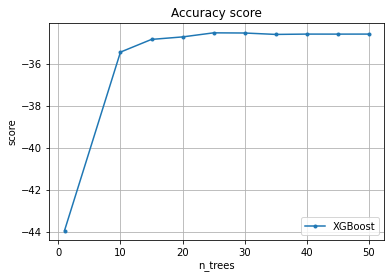

In [156]:
plt.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
plt.grid(True)
plt.xlabel('n_trees')
plt.ylabel('score')
plt.title('Accuracy score')
plt.legend(loc='lower right')

In [152]:
depths = [1] + list(range(10, 100, 5))

xgb_scoring = []
for d in depths:
    estimator = xgb.XGBRegressor(objective='reg:squarederror',learning_rate=0.1, max_depth=d, n_estimators=100, min_child_weight=3)
    score = model_selection.cross_val_score(estimator, X, y, 
                                             scoring = 'neg_mean_squared_error', cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

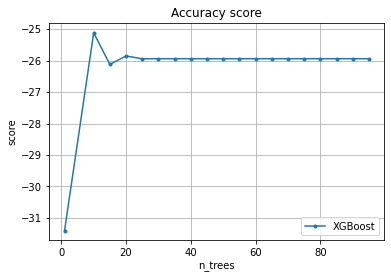

In [153]:
plt.plot(depths, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
plt.grid(True)
plt.xlabel('n_trees')
plt.ylabel('score')
plt.title('Accuracy score')
plt.legend(loc='lower right')

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [158]:
from  sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
mean_squared_error(y_test, y_pred, squared = False)

8.254979753549161